#Instalasi dan Inisialisasi


In [1]:
# Instal PySpark jika belum terinstal
!pip install pyspark

# Import library yang diperlukan
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, isnan, isnull, sum
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Membuat Spark Session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Online News Sentiment Analysis") \
    .getOrCreate()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=6c54ecf9d59c76e0f76d3d0e98ce8f76e6a29153a9eb46bea54736806a2b949f
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
# Mengunduh dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip

# Mengekstrak dataset
!unzip OnlineNewsPopularity.zip


--2024-09-15 14:55:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘OnlineNewsPopularity.zip’

OnlineNewsPopularit     [   <=>              ]   7.13M  15.5MB/s    in 0.5s    

2024-09-15 14:55:28 (15.5 MB/s) - ‘OnlineNewsPopularity.zip’ saved [7476401]

Archive:  OnlineNewsPopularity.zip
   creating: OnlineNewsPopularity/
  inflating: OnlineNewsPopularity/OnlineNewsPopularity.names  
  inflating: OnlineNewsPopularity/OnlineNewsPopularity.csv  


#Eksplorasi Dataset

In [3]:
# Memuat dataset
data = spark.read.csv("OnlineNewsPopularity/OnlineNewsPopularity.csv", header=True, inferSchema=True)


In [4]:
# Membersihkan nama kolom
for col_name in data.columns:
    data = data.withColumnRenamed(col_name, col_name.strip().replace(' ', '').replace('.', '_').replace('%', 'percent'))


In [5]:
# Kolom-kolom sentimen yang akan digunakan
sentiment_cols = [
    'global_subjectivity',
    'global_sentiment_polarity',
    'global_rate_positive_words',
    'global_rate_negative_words',
    'rate_positive_words',
    'rate_negative_words',
    'avg_positive_polarity',
    'min_positive_polarity',
    'max_positive_polarity',
    'avg_negative_polarity',
    'min_negative_polarity',
    'max_negative_polarity',
    'shares'  # Menambahkan 'shares' untuk analisis lebih lanjut
]

data_sentiment = data.select(sentiment_cols)


In [6]:
# Menampilkan skema
data_sentiment.printSchema()


root
 |-- global_subjectivity: double (nullable = true)
 |-- global_sentiment_polarity: double (nullable = true)
 |-- global_rate_positive_words: double (nullable = true)
 |-- global_rate_negative_words: double (nullable = true)
 |-- rate_positive_words: double (nullable = true)
 |-- rate_negative_words: double (nullable = true)
 |-- avg_positive_polarity: double (nullable = true)
 |-- min_positive_polarity: double (nullable = true)
 |-- max_positive_polarity: double (nullable = true)
 |-- avg_negative_polarity: double (nullable = true)
 |-- min_negative_polarity: double (nullable = true)
 |-- max_negative_polarity: double (nullable = true)
 |-- shares: double (nullable = true)



In [7]:
# Menampilkan data
data_sentiment.show(5)


+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+------+
|global_subjectivity|global_sentiment_polarity|global_rate_positive_words|global_rate_negative_words|rate_positive_words|rate_negative_words|avg_positive_polarity|min_positive_polarity|max_positive_polarity|avg_negative_polarity|min_negative_polarity|max_negative_polarity|shares|
+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+------+
|     0.521617145481|          0.0925619834711|           0.0456621004566|            0.013698630137|     0.769230769231|     0.230769230769|       0.3786363

In [8]:
# Menghitung nilai yang hilang
missing_values = data_sentiment.select([sum(isnull(c).cast("int")).alias(c) for c in data_sentiment.columns])
missing_values.show()


+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+------+
|global_subjectivity|global_sentiment_polarity|global_rate_positive_words|global_rate_negative_words|rate_positive_words|rate_negative_words|avg_positive_polarity|min_positive_polarity|max_positive_polarity|avg_negative_polarity|min_negative_polarity|max_negative_polarity|shares|
+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+------+
|                  0|                        0|                         0|                         0|                  0|                  0|                

#Transformasi Data

In [9]:
#Kita akan membuat label positif atau negatif berdasarkan nilai global_sentiment_polarity.

#Jika global_sentiment_polarity > 0, label = 1 (positif)
#Jika global_sentiment_polarity ≤ 0, label = 0 (negatif)

# Membuat kolom label
data_sentiment = data_sentiment.withColumn("label", when(col("global_sentiment_polarity") > 0, 1).otherwise(0))


In [10]:
# Distribusi label
data_sentiment.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|    1|35183|
|    0| 4461|
+-----+-----+



#Visualisasi

In [11]:
# Mengambil sampel data untuk visualisasi
sample_data = data_sentiment.sample(False, 0.1).toPandas()


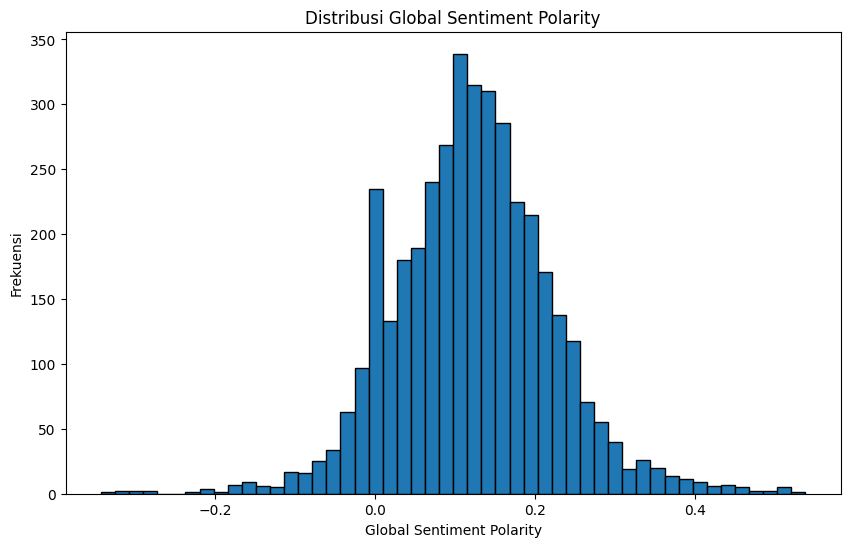

In [12]:
plt.figure(figsize=(10,6))
plt.hist(sample_data['global_sentiment_polarity'], bins=50, edgecolor='k')
plt.title("Distribusi Global Sentiment Polarity")
plt.xlabel("Global Sentiment Polarity")
plt.ylabel("Frekuensi")
plt.show()


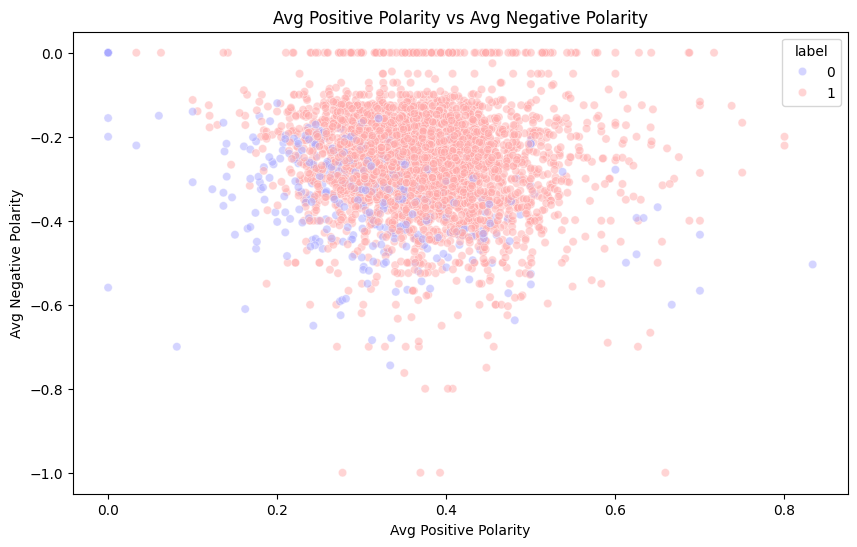

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='avg_positive_polarity', y='avg_negative_polarity', hue='label', data=sample_data, palette='bwr', alpha=0.5)
plt.title("Avg Positive Polarity vs Avg Negative Polarity")
plt.xlabel("Avg Positive Polarity")
plt.ylabel("Avg Negative Polarity")
plt.show()


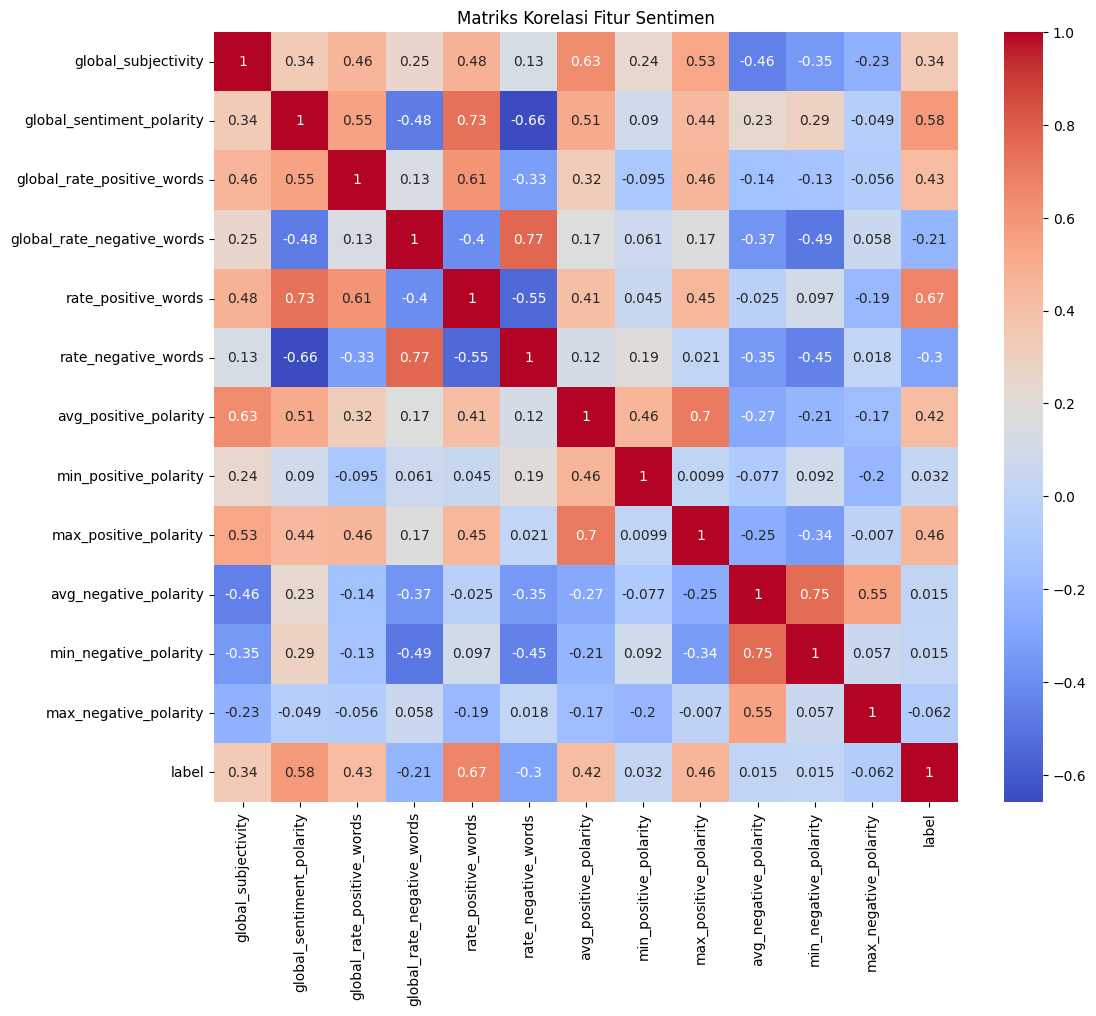

In [14]:
plt.figure(figsize=(12,10))
corr = sample_data.drop(['shares'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriks Korelasi Fitur Sentimen")
plt.show()


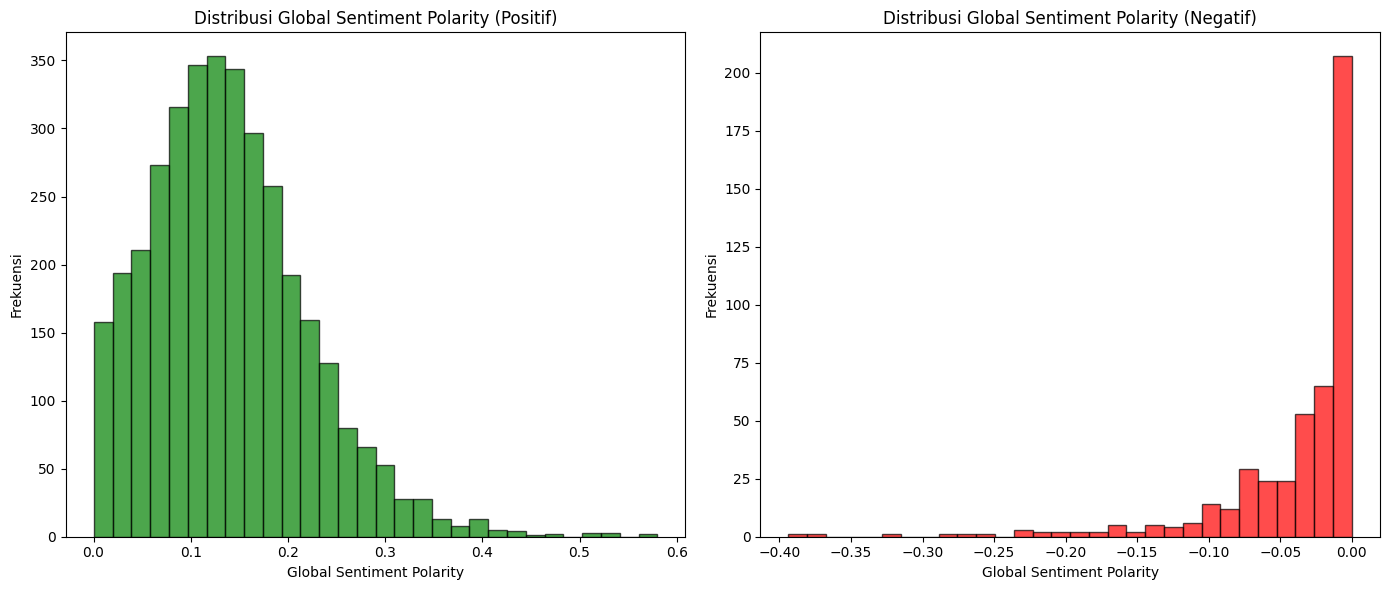

In [20]:
# Memisahkan data berdasarkan label
positive_news = sample_data[sample_data['label'] == 1]
negative_news = sample_data[sample_data['label'] == 0]

# Plot histogram untuk global_sentiment_polarity
plt.figure(figsize=(14,6))

# Histogram untuk berita positif
plt.subplot(1, 2, 1)
plt.hist(positive_news['global_sentiment_polarity'], bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribusi Global Sentiment Polarity (Positif)')
plt.xlabel('Global Sentiment Polarity')
plt.ylabel('Frekuensi')

# Histogram untuk berita negatif
plt.subplot(1, 2, 2)
plt.hist(negative_news['global_sentiment_polarity'], bins=30, color='red', edgecolor='black', alpha=0.7)
plt.title('Distribusi Global Sentiment Polarity (Negatif)')
plt.xlabel('Global Sentiment Polarity')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()


In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Fitur yang digunakan (tidak termasuk 'shares' dan 'label')
feature_cols = [col for col in sentiment_cols if col not in ('shares')]

# Vector Assembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Dataset akhir
final_data = assembler.transform(data_sentiment).select("features", "label")


In [22]:
# Split data
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)


In [23]:
from pyspark.ml.classification import LogisticRegression

# Inisialisasi model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Melatih model
lr_model = lr.fit(train_data)


In [24]:
# Prediksi
predictions = lr_model.transform(test_data)

# Evaluasi
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName='areaUnderROC')

auc = evaluator.evaluate(predictions)
print(f"AUC pada data testing: {auc}")


AUC pada data testing: 0.9985833605654094


In [25]:
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   35|
|    0|       0.0| 1206|
|    1|       1.0|10397|
|    0|       1.0|   80|
+-----+----------+-----+

